In [1]:
'''
1) sci-kit view_as_window - patching works but no built in recon (didn't try with non overlapping windows
2) sci-kit batch - patching, recon don't work
2) tf extract_image_patches - patching works, wrote function to recon nonoverlapping, runs out of memory when training GAN (2nd epoch)
3) tf extract_image_patches - tried saving all images locally before training, patching creates color shifts, recon works
4) tf space_to_batch reshape (16, 64, 80) - recon works but patching has bits of each image in each patch
5) tf space_to_batch reshape using transpose - some patches work but corners have color shift like in (3)

'''

"\n1) sci-kit view_as_window - patching works but no built in recon (didn't try with non overlapping windows\n2) sci-kit batch - patching, recon don't work\n2) tf extract_image_patches - patching works, wrote function to recon nonoverlapping, runs out of memory when training GAN (2nd epoch)\n3) tf extract_image_patches - tried saving all images locally before training, patching creates color shifts, recon works\n4) tf space_to_batch reshape (16, 64, 80) - recon works but patching has bits of each image in each patch\n5) tf space_to_batch reshape using transpose - some patches work but corners have color shift like in (3)\n\n\n\n\n"

In [1]:
import os
import scipy.misc
from skimage.util.shape import view_as_windows
from sklearn.feature_extraction import image
import numpy as np

from forward_model import DCGAN
from utils import pp, visualize, to_json, show_all_variables

import tensorflow as tf

from glob import glob
from ops import *
from utils import *

import matplotlib.pyplot as plt
import ra

%matplotlib notebook

In [2]:
#flags

flags = tf.app.flags
flags.DEFINE_integer("epoch", 15, "Epoch to train [20]") # changed to 20 from  25
flags.DEFINE_float("learning_rate", 0.0002, "Learning rate of for adam [0.0002]")
flags.DEFINE_float("beta1", 0.5, "Momentum term of adam [0.5]")
flags.DEFINE_integer("train_size", np.inf, "The size of train images [np.inf]")
flags.DEFINE_integer("batch_size", 16, "The size of batch images [64]")
flags.DEFINE_integer("input_height", 256, "The size of image to use (will be center cropped). [108]")
flags.DEFINE_integer("input_width", 320, "The size of image to use (will be center cropped). If None, same value as input_height [None]")
flags.DEFINE_integer("output_height", 256, "The size of the output images to produce [64]")
flags.DEFINE_integer("output_width", 320, "The size of the output images to produce. If None, same value as output_height [None]")
flags.DEFINE_string("dataset", "train_img_slices", "The name of dataset [celebA, mnist, lsun]")
flags.DEFINE_string("input_fname_pattern", "*.jpg", "Glob pattern of filename of input images [*]")
flags.DEFINE_string("checkpoint_dir", "checkpoint", "Directory name to save the checkpoints [checkpoint]")
flags.DEFINE_string("sample_dir", "samples", "Directory name to save the image samples [samples]")
flags.DEFINE_boolean("train", False, "True for training, False for testing [False]")
flags.DEFINE_boolean("crop", True, "True for training, False for testing [False]")
flags.DEFINE_boolean("visualize", False, "True for visualizing, False for nothing [False]")
FLAGS = flags.FLAGS

pp.pprint(flags.FLAGS.__flags)

if FLAGS.input_width is None:
    FLAGS.input_width = FLAGS.input_height
if FLAGS.output_width is None:
    FLAGS.output_width = FLAGS.output_height

if not os.path.exists(FLAGS.checkpoint_dir):
    os.makedirs(FLAGS.checkpoint_dir)
if not os.path.exists(FLAGS.sample_dir):
    os.makedirs(FLAGS.sample_dir)

#gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.333)
run_config = tf.ConfigProto()
run_config.gpu_options.allow_growth=True

{}


In [23]:
def patch_new(path, height=64, width=80):
  #with tf.Session() as sess:
   image_ = get_image_old(path)
   img = (tf.space_to_batch_nd(input=tf.expand_dims(tf.expand_dims(image_, 0), 3), block_shape=[64, 80], 
                                   paddings=[[0, 0], [0, 0]]).eval())
   print(np.shape(img[:, 0, 0]))
   print(np.shape(img))
   a = np.transpose(img, (1, 2, 0, 3))
   a = np.reshape(a, ((16, 64, 80)))
   print(np.shape(a))
   return a

In [ ]:
data = glob("./data/train_img_slices/*.ra")

sample_files = data[0:1]

with tf.Session() as sess:
    first = get_image_old(sample_files[0])
    sample_patch = patch_new(sample_files[0])
    for i in range(1, len(sample_files)):
        sample_patch = np.vstack((sample_patch, patch_new(sample_files[i])))
    print(np.shape(sample_patch))
    #a = tf.batch_to_space_nd(tf.reshape(sample_patch[0:16], [5120, 4, 4, 1]), block_shape=[64, 80], crops=[[0, 0], [0, 0]])
    #a = tf.reshape(a, [256, 320]).eval()
    #print(np.shape(a))
    plt.imshow(sample_patch[4], cmap ='gray')
    plt.show()

(5120, 1)
(5120, 4, 4, 1)
(16, 64, 80)
(16, 64, 80)


<IPython.core.display.Javascript object>

In [10]:
def addZeros(i):
    while len(str(i)) < 5:
        i = str('0' + str(i))
    return i

data = glob("./data/train_img_slices/*.ra")
print(len(data))
sample_files = data
first = get_image_old(sample_files[0])
with tf.Session() as sess:
    count = 0
    for i in range(0, len(sample_files)):
        if i % 100 == 0:
            print(i)
        sample_patch = get_image(sample_files[i])
        for k in range(0, len(sample_patch)):
            np.save("./Patches/{0}.npy".format(str(addZeros(count))), sample_patch[k])
            count += 1
    #for i in range(1, len(sample_files)):
        #sample_patch = np.vstack((sample_patch, get_image(sample_files[i])))
    #print(np.shape(sample_patch))
    
#for i in range(len(sample_patch)):
    #scipy.misc.imsave(("./Patches/{0}.png").format(str(addZeros(i))), (sample_patch[i]))
#    np.save("./Patches/{0}.npy".format(str(addZeros(i))), sample_patch[i])
    

2880
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800


./Patches/00048.npy
./Patches/00049.npy
./Patches/00050.npy
./Patches/00051.npy
./Patches/00052.npy
./Patches/00053.npy
./Patches/00054.npy
./Patches/00055.npy
./Patches/00056.npy
./Patches/00057.npy
./Patches/00058.npy
./Patches/00059.npy
./Patches/00060.npy
./Patches/00061.npy
./Patches/00062.npy
./Patches/00063.npy


<IPython.core.display.Javascript object>


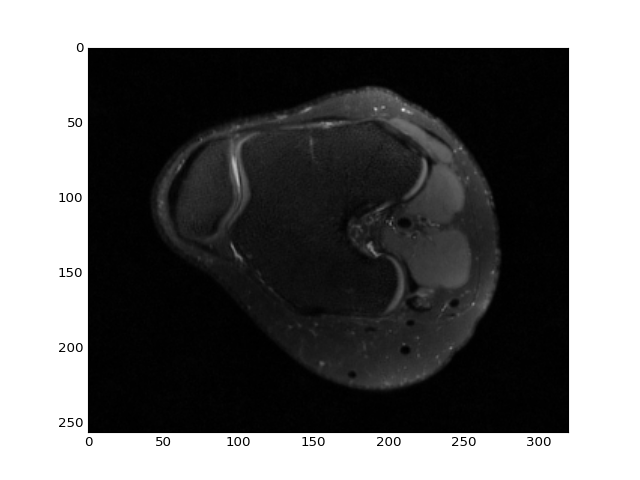

In [17]:
data = sorted(glob("./Patches/*.npy"))
sample = data[48:64]
for s in sample:
    print(s)
#img = [imread_old(d) for d in sample]
img = [np.load(d) for d in sample]
first_recon = patch_together(img)
plt.imshow(first_recon, cmap ='gray')
plt.show()

In [3]:
data = glob("./data/train_img_slices/*.ra")

sample_files = data[0:16]

with tf.Session() as sess:
    first = get_image_old(sample_files[0])
    sample_patch = get_image(sample_files[0])
    for i in range(1, len(sample_files)):
        sample_patch = np.vstack((sample_patch, get_image(sample_files[i])))
    print(np.shape(sample_patch))

(256, 64, 80)


(16, 64, 80)


<IPython.core.display.Javascript object>


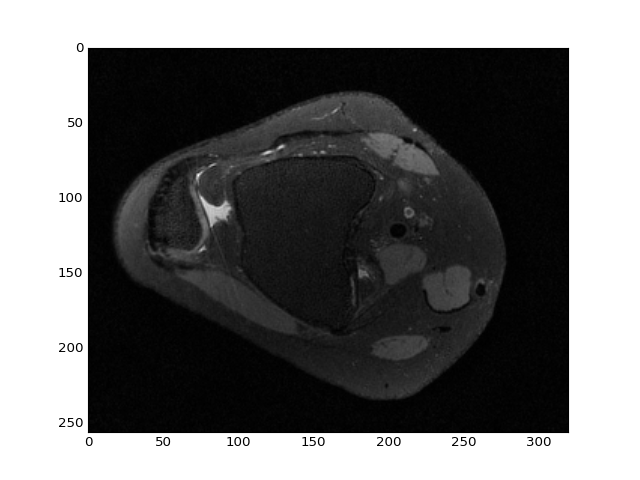

True


In [4]:
img = sample_patch[0:16]
print(np.shape(img))
first_recon = patch_together(img)
plt.imshow(first_recon, cmap ='gray')
plt.show()
print((first_recon == first).all())

In [ ]:
v = np.reshape(sample, (16, 256*320))
# number of features per image (pixels including all channels)
print('shape of v: {}'.format(v.shape))


n = v.shape[1]

In [ ]:
num_iter = 5
compressed_images = []

plt.imshow(sample[0], cmap='gray')
plt.show()


with tf.Session() as sess:

    #print(tf.global_variables())

    dcgan = DCGAN(
        sess,
        input_width=FLAGS.input_width,
        input_height=FLAGS.input_height,
        output_width=FLAGS.output_width,
        output_height=FLAGS.output_height,
        batch_size=FLAGS.batch_size,
        sample_num=FLAGS.batch_size,
        dataset_name=FLAGS.dataset,
        input_fname_pattern=FLAGS.input_fname_pattern,
        crop=FLAGS.crop,
        checkpoint_dir=FLAGS.checkpoint_dir,
        sample_dir=FLAGS.sample_dir)



    if not dcgan.load(FLAGS.checkpoint_dir)[0]:
        raise Exception("[!] Train a model first, then run test mode")

    dcgan.z.initializer.run()

    for i in range(1):
        #A1 = np.random.randn(n, m//2).astype('float32')
        #A1 = A1 / (np.sqrt(2) * np.sqrt( np.sum( A1**2, axis = 1 ) ))[:,None]
        #A2 = np.random.randn(n, m//2).astype('float32')
        #A2 = A2 / (np.sqrt(2) * np.sqrt( np.sum( A2**2, axis = 1 ) ))[:,None]
        
#         A_init = np.random.randn(n, m).astype('float32') 
#         A_init = A_init / np.sqrt( np.sum( A_init**2, axis = 1 ) )[:,None]
#         A_placeholder = tf.placeholder(tf.float32, shape=A_init.shape)
#         A = tf.Variable(A_placeholder)
        
        #A = np.random.randn(n, m).astype('float32')
        #A = A / np.sqrt( np.sum( A**2, axis = 1 ) )[:,None]
 
        
        #y = np.dot(v, A) 
        #y = np.hstack((np.dot(v, A1), np.dot(v, A2)))
        print('number of measurements = {}'.format(m))
        count = 0
        y_placeholder = tf.placeholder(tf.complex64,[None,m])
        
        g_kspace = tf.fft2d(tf.cast(dcgan.G[0],dtype=tf.complex64))
        g_kspace_samples = tf.boolean_mask(g_kspace,the_mask)
        
        # -----------------------------------
#         our_loss = tf.reduce_mean( tf.reduce_sum( (tf.matmul(tf.reshape(dcgan.G, [16, -1]) , A) - y_placeholder)**2, 1)) 
        our_loss = tf.reduce_mean( tf.reduce_sum( tf.abs(g_kspace_samples - y_placeholder)**2, 1)) 
        #our_loss = tf.reduce_mean( 
        #    tf.reduce_sum( (tf.concat ([tf.matmul(tf.reshape(dcgan.G, [16, -1]) , A1), 
        #                                 tf.matmul(tf.reshape(dcgan.G, [16, -1]) , A2)], axis=1) - y_placeholder)**2, 1))
        # -----------------------------------

        z_optim = tf.train.AdamOptimizer(learning_rate=0.1).minimize(our_loss, var_list=dcgan.z)  

        opt_initializers   = [var.initializer for var in tf.global_variables() if 'Adam' in var.name]
        beta1_initializers = [var.initializer for var in tf.global_variables() if 'beta1_power' in var.name]
        beta2_initializers = [var.initializer for var in tf.global_variables() if 'beta2_power' in var.name]

        sess.run(opt_initializers)
        sess.run(beta1_initializers)
        sess.run(beta2_initializers)


        for i in range(num_iter): 
            print('iteration {}'.format(count))
            a, closs, b = sess.run([z_optim, our_loss, dcgan.G],feed_dict={y_placeholder: y})
            count += 1
            print(closs)
        plt.imshow(b[0].reshape((256, 320)), cmap='gray')
        compressed_images.append(b)
        plt.show()